# Fine-tuning GPT-4o-mini on Hacker News

Some helper functions were taken from [OpenAI Cookbook](https://cookbook.openai.com/examples/chat_finetuning_data_prep) and [OpenAI Docs](https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset). If something's less well documented here, it's because it's explained in one of the two sources.

In [1]:
# Imports
import openai
import tiktoken
import json
import os
import requests
import time
import random
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from IPython.display import Markdown, display
from requests.exceptions import RequestException

In [2]:
# Setup
openai_api_key = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI(api_key=openai_api_key)

firecrawl_api_key = os.getenv("FIRECRAWL_API_KEY")

In [52]:
# === FUNCTIONS ===

# === Scraping ===

def build_comment_tree(comments, root_ids, depth=0, max_depth=5, comments_per_level=3):
    if depth >= max_depth:
        return []
    
    tree = []
    for id in root_ids[:comments_per_level]:
        if id in comments:
            comment = comments[id]
            comment['replies'] = build_comment_tree(comments, comment['kids'], depth + 1, max_depth, comments_per_level)
            tree.append(comment)
    return tree

def fetch_comments_recursive(item_id, base_url, depth=0, max_depth=5, comments_per_level=3):
    if depth >= max_depth:
        return None

    item_response = make_request_with_backoff(f"{base_url}/item/{item_id}.json")
    if not item_response:
        return None

    item = item_response.json()
    if item['type'] != 'comment':
        return None

    comment = {
        'id': item['id'],
        'by': item.get('by', 'deleted'),
        'text': item.get('text', ''),
        'score': item.get('score', 0),
        'kids': []
    }

    for kid_id in item.get('kids', [])[:comments_per_level]:
        kid_comment = fetch_comments_recursive(kid_id, base_url, depth + 1, max_depth, comments_per_level)
        if kid_comment:
            comment['kids'].append(kid_comment)

    return comment

def comment_to_markdown(comment, indent=""):
    score_indicator = "↑" if comment['score'] > 5 else "↓" if comment['score'] < 0 else ""
    md = f"{indent}- **{comment['by']}** ({score_indicator}): {comment['text']}\n"
    for kid in comment['kids']:
        md += comment_to_markdown(kid, indent + "  ")
    return md


def exponential_backoff(attempt, base_delay=1, max_delay=60):
    delay = min(base_delay * (2 ** attempt) + random.uniform(0, 1), max_delay)
    time.sleep(delay)

def make_request_with_backoff(url, method='get', headers=None, json=None, max_retries=5):
    for attempt in range(max_retries):
        try:
            if method == 'get':
                response = requests.get(url, headers=headers)
            elif method == 'post':
                response = requests.post(url, headers=headers, json=json)
            
            if response.status_code == 200:
                return response
            elif response.status_code == 429:
                print(f"Rate limit hit. Retrying after backoff...")
                exponential_backoff(attempt)
            else:
                print(f"Request failed with status code: {response.status_code}")
                return None
        except RequestException as e:
            print(f"Request exception: {str(e)}")
        
        if attempt < max_retries - 1:
            exponential_backoff(attempt)
    
    print(f"Max retries reached. Request failed.")
    return None

def scrape_hacker_news(num_stories=10, comments_per_level=3, max_depth=5):
    base_url = "https://hacker-news.firebaseio.com/v0"
    
    best_stories_response = make_request_with_backoff(f"{base_url}/beststories.json")
    if not best_stories_response:
        print("Failed to fetch best stories. Exiting.")
        return []
    
    best_stories = best_stories_response.json()[:num_stories]
    
    dataset = []
    skipped_stories = 0
    
    for story_id in tqdm(best_stories, desc="Scraping stories"):
        print(f"\nProcessing story ID: {story_id}")
        story_response = make_request_with_backoff(f"{base_url}/item/{story_id}.json")
        if not story_response:
            print(f"Failed to fetch story {story_id}. Skipping.")
            skipped_stories += 1
            continue
        
        story = story_response.json()
        
        if 'url' not in story:
            print(f"Skipping story {story_id}: No URL found")
            skipped_stories += 1
            continue
        
        print(f"Fetching content for URL: {story['url']}")
        
        firecrawl_response = make_request_with_backoff(
            "https://api.firecrawl.dev/v0/scrape",
            method='post',
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {firecrawl_api_key}"
            },
            json={
                "url": story['url'],
                "pageOptions": {
                    "onlyMainContent": True
                }
            }
        )
        
        if firecrawl_response:
            article_content = firecrawl_response.json()['data']['content']
            print(f"Successfully fetched content for story {story_id}")
        else:
            print(f"Skipping story {story_id}: Failed to fetch content")
            skipped_stories += 1
            continue
        
        comment_tree = []
        for comment_id in story.get("kids", [])[:comments_per_level]:
            comment = fetch_comments_recursive(comment_id, base_url, 0, max_depth, comments_per_level)
            if comment:
                comment_tree.append(comment)
        
        print(f"Fetched {len(comment_tree)} top-level comments for story {story_id}")
        
        # Create markdown representation of comments
        markdown_comments = "\n"
        for c in comment_tree:
            markdown_comments += comment_to_markdown(c)
        
        entry = {
            "messages": [
                {
                    "role": "system",
                    "content": "You are a helpful assistant that generates a comment section for given articles. Provide thoughtful and diverse comments that might appear on a tech-focused news site."
                },
                {
                    "role": "user",
                    "content": f"Please generate a comment section for the following article:\n\nTitle: {story.get('title', 'No Title')}\n\nURL: {story.get('url', 'N/A')}\n\nContent: {article_content}\n\n-----\nGenerate comments in a hierarchical structure with {comments_per_level} comments per level, up to a depth of {max_depth}."
                },
                {
                    "role": "assistant",
                    "content": markdown_comments if markdown_comments else "Here are some potential comments for this article:"
                }
            ]
        }
        
        dataset.append(entry)
        print(f"Added story {story_id} to dataset. Current dataset size: {len(dataset)}")

        if len(dataset) >= num_stories:
            break
        
        time.sleep(1)  # Add a small delay between stories to be respectful
    
    print(f"\nScraping completed. Total stories processed: {len(best_stories)}")
    print(f"Stories added to dataset: {len(dataset)}")
    print(f"Stories skipped: {skipped_stories}")
    
    return dataset

def fetch_example_article(url):
    firecrawl_response = make_request_with_backoff(
        "https://api.firecrawl.dev/v0/scrape",
        method='post',
        headers={
            "Content-Type": "application/json",
            "Authorization": f"Bearer {firecrawl_api_key}"
        },
        json={
            "url": url,
            "pageOptions": {
                "onlyMainContent": True
            }
        }
    )
    
    if firecrawl_response:
        article_content = firecrawl_response.json()['data']['content']
        print(f"Successfully fetched content for URL: {url}")
        return article_content
    else:
        print(f"Failed to fetch content for URL: {url}")
        return "Failed to fetch content"


# === Data Loading ===

def load_data(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        dataset = [json.loads(line) for line in f]
    return dataset


# === Data Cleaning ===

def is_article_link(client, url, title, content):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            response_format={ "type": "json_object" },
            messages=[
                {"role": "system", "content": "You are a helpful assistant that determines if a given URL, title, and content likely constitute an article or article-like content suitable for generating comments. Respond with a JSON object containing a boolean 'is_suitable' field and a 'reason' field explaining your decision."},
                {"role": "user", "content": f"""URL: {url}
Title: {title}
Content: {content[:2000]}...

Is this content suitable for generating comments? Consider the following:
1. Traditional articles are ideal, but also include article-like content such as product pages, announcements, or blog posts.
2. The content should have enough substance to generate meaningful comments.
3. Include pages that might be part of a larger piece (e.g., a section of a course or a chapter of a book) if they contain sufficient standalone information.
4. Exclude pages that are clearly just navigation, lists of links, or purely interactive content without substantial text.
5. When in doubt, lean towards inclusion rather than exclusion.

Respond with whether this content is suitable for comment generation and explain your reasoning very briefly."""}
            ]
        )
        
        result = json.loads(response.choices[0].message.content)
        return result['is_suitable'], result['reason']
    except Exception as e:
        print(f"Error processing URL {url}: {str(e)}")
        return False, "Error occurred during processing"

def verify_articles(dataset, client):
    verified_dataset = []
    
    for entry in tqdm(dataset, desc="Verifying content"):
        user_message = entry['messages'][1]['content']
        title = user_message.split('Title: ')[1].split('\n')[0]
        url = user_message.split('URL: ')[1].split('\n')[0]
        content = user_message.split('Content: ')[1].split('\n\nGenerate comments')[0]
        
        is_suitable, reason = is_article_link(client, url, title, content)
        
        if is_suitable:
            verified_dataset.append(entry)
        else:
            print(f"Skipping unsuitable content: {url} - Reason: {reason}")
    
    return verified_dataset
    
def filter_long_examples(dataset, max_tokens):
    filtered_dataset = []
    for example in dataset:
        tokens = num_tokens_from_messages(example["messages"])
        if tokens <= max_tokens:
            filtered_dataset.append(example)
    return filtered_dataset


# === Fine-tuning

def upload_training_file(client, file_path):
    with open(file_path, "rb") as file:
        response = client.files.create(
            file=file,
            purpose="fine-tune"
        )
    return response.id

def create_fine_tuning_job(client, training_file_id, model="gpt-4o-mini-2024-07-18"):
    response = client.fine_tuning.jobs.create(
        training_file=training_file_id,
        model=model
    )
    return response.id

def check_fine_tuning_status(client, job_id):
    response = client.fine_tuning.jobs.retrieve(job_id)
    return response.status

def test_fine_tuned_model(client, model_id, article_title, article_url, article_content, comments_per_level, depth):
    try:
        response = client.chat.completions.create(
            model=model_id,
            # temperature=0.3,  # this produced weird results, probably because training temperature was different (default, 0.7)
            messages=[
                {"role": "system", "content": "You are a helpful assistant that generates a comment section for given articles. Provide thoughtful and diverse comments that might appear on a tech-focused news site."},
                {"role": "user", "content": f"Please generate a comment section for the following article:\n\nTitle: {article_title}\n\nURL: {article_url}\n\nContent: {article_content}...\n\n-----\nGenerate english comments in a hierarchical structure with {comments_per_level} comments per level, up to a depth of {depth}."}
            ],
            # max_tokens=1000
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"


# === Helper Functions ===

def check_data_validity(dataset):
    # Format error checks
    format_errors = defaultdict(int)

    for ex in dataset:
        if not isinstance(ex, dict):
            format_errors["data_type"] += 1
            continue
            
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue
            
        for message in messages:
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1
            
            if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
                format_errors["message_unrecognized_key"] += 1
            
            if message.get("role", None) not in ("system", "user", "assistant", "function"):
                format_errors["unrecognized_role"] += 1
                
            content = message.get("content", None)
            function_call = message.get("function_call", None)
            
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1
        
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1

    if format_errors:
        print("Found errors:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
    else:
        print("No errors found")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

def data_warnings_and_token_count(dataset):
    # Warnings and tokens counts
    n_missing_system = 0
    n_missing_user = 0
    n_messages = []
    convo_lens = []
    assistant_message_lens = []

    for ex in dataset:
        messages = ex["messages"]
        if not any(message["role"] == "system" for message in messages):
            n_missing_system += 1
        if not any(message["role"] == "user" for message in messages):
            n_missing_user += 1
        n_messages.append(len(messages))
        convo_lens.append(num_tokens_from_messages(messages))
        assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
        
    print("Num examples missing system message:", n_missing_system)
    print("Num examples missing user message:", n_missing_user)
    print_distribution(n_messages, "num_messages_per_example")
    print_distribution(convo_lens, "num_total_tokens_per_example")
    print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
    n_too_long = sum(l > 65536 for l in convo_lens)
    print(f"\n{n_too_long} examples may be over the 65,536 token limit, they will be truncated during fine-tuning")

    return convo_lens

def cost_estimate(dataset, convo_lens, max_tokens_per_example=65536, target_epochs=3, min_target_examples=100, max_target_examples=25000, min_default_epochs=1, max_default_epochs=25):
    n_epochs = target_epochs
    n_train_examples = len(dataset)
    if n_train_examples * target_epochs < min_target_examples:
        n_epochs = min(max_default_epochs, min_target_examples // n_train_examples)
    elif n_train_examples * target_epochs > max_target_examples:
        n_epochs = max(min_default_epochs, max_target_examples // n_train_examples)

    n_billing_tokens_in_dataset = sum(min(max_tokens_per_example, length) for length in convo_lens)
    print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
    print(f"By default, you'll train for {n_epochs} epochs on this dataset")
    print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

## 1) Scrape Hacker News

In [4]:
# scrape stories
# we need 50 examples but fetch some more to account for skipped ones due to errors
NUM_STORIES = 55
dataset = scrape_hacker_news(num_stories=NUM_STORIES, comments_per_level=3, max_depth=3)

# Save to JSONL file
data_path = "data/hacker_news_data.jsonl"
with open(data_path, 'w', encoding='utf-8') as f:
    for entry in dataset:
        json.dump(entry, f)
        f.write('\n')

print(f"Data saved to {data_path}")

Scraping stories:   0%|          | 0/55 [00:00<?, ?it/s]


Processing story ID: 41060102
Fetching content for URL: https://trufflesecurity.com/blog/anyone-can-access-deleted-and-private-repo-data-github
Successfully fetched content for story 41060102
Fetched 3 top-level comments for story 41060102
Added story 41060102 to dataset. Current dataset size: 1


Scraping stories:   2%|▏         | 1/55 [00:11<10:36, 11.79s/it]


Processing story ID: 41069829
Fetching content for URL: https://deepmind.google/discover/blog/ai-solves-imo-problems-at-silver-medal-level/
Successfully fetched content for story 41069829
Fetched 3 top-level comments for story 41069829
Added story 41069829 to dataset. Current dataset size: 2


Scraping stories:   4%|▎         | 2/55 [00:26<12:10, 13.79s/it]


Processing story ID: 41064351
Fetching content for URL: https://github.com/nodejs/node/pull/53725
Successfully fetched content for story 41064351
Fetched 3 top-level comments for story 41064351
Added story 41064351 to dataset. Current dataset size: 3


Scraping stories:   5%|▌         | 3/55 [00:40<11:47, 13.61s/it]


Processing story ID: 41065227
Fetching content for URL: https://www.elysian.press/p/employee-ownership
Successfully fetched content for story 41065227
Fetched 3 top-level comments for story 41065227
Added story 41065227 to dataset. Current dataset size: 4


Scraping stories:   7%|▋         | 4/55 [00:52<11:03, 13.00s/it]


Processing story ID: 41088013
Fetching content for URL: https://cybernetic.dev/grid
Successfully fetched content for story 41088013
Fetched 3 top-level comments for story 41088013
Added story 41088013 to dataset. Current dataset size: 5


Scraping stories:   9%|▉         | 5/55 [01:01<09:30, 11.40s/it]


Processing story ID: 41075766
Fetching content for URL: https://www.bloomberg.com/news/articles/2024-07-26/zurich-bern-consider-billboard-bans-after-vernier-outlaws-visual-pollution
Successfully fetched content for story 41075766
Fetched 3 top-level comments for story 41075766
Added story 41075766 to dataset. Current dataset size: 6


Scraping stories:  11%|█         | 6/55 [01:11<09:10, 11.24s/it]


Processing story ID: 41058107
Fetching content for URL: https://mistral.ai/news/mistral-large-2407/
Successfully fetched content for story 41058107
Fetched 3 top-level comments for story 41058107
Added story 41058107 to dataset. Current dataset size: 7


Scraping stories:  13%|█▎        | 7/55 [01:21<08:34, 10.71s/it]


Processing story ID: 41064645
Fetching content for URL: https://jordaneldredge.com/notes/corrupted-skins/
Successfully fetched content for story 41064645
Fetched 3 top-level comments for story 41064645
Added story 41064645 to dataset. Current dataset size: 8


Scraping stories:  15%|█▍        | 8/55 [01:29<07:37,  9.74s/it]


Processing story ID: 41069256
Fetching content for URL: https://0xinfection.github.io/reversing/
Successfully fetched content for story 41069256
Fetched 3 top-level comments for story 41069256
Added story 41069256 to dataset. Current dataset size: 9


Scraping stories:  16%|█▋        | 9/55 [01:38<07:18,  9.54s/it]


Processing story ID: 41068719
Fetching content for URL: https://haystackeditor.com/
Successfully fetched content for story 41068719
Fetched 3 top-level comments for story 41068719
Added story 41068719 to dataset. Current dataset size: 10


Scraping stories:  18%|█▊        | 10/55 [02:00<10:10, 13.58s/it]


Processing story ID: 41057033
Fetching content for URL: https://www.404media.co/google-is-the-only-search-engine-that-works-on-reddit-now-thanks-to-ai-deal/
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41057033
Fetched 3 top-level comments for story 41057033
Added story 41057033 to dataset. Current dataset size: 11


Scraping stories:  20%|██        | 11/55 [02:11<09:17, 12.67s/it]


Processing story ID: 41052365
Fetching content for URL: https://martin.janiczek.cz/2024/07/23/taking-my-diabetes-treatment-into-my-own-hands.html
Successfully fetched content for story 41052365
Fetched 3 top-level comments for story 41052365
Added story 41052365 to dataset. Current dataset size: 12


Scraping stories:  22%|██▏       | 12/55 [02:20<08:18, 11.58s/it]


Processing story ID: 41090304
Fetching content for URL: https://doubleagent.net/onavo-facebook-ssl-mitm-technical-analysis/
Successfully fetched content for story 41090304
Fetched 3 top-level comments for story 41090304
Added story 41090304 to dataset. Current dataset size: 13


Scraping stories:  24%|██▎       | 13/55 [02:31<07:59, 11.42s/it]


Processing story ID: 41080991
Fetching content for URL: https://tailscale.com/blog/new-internet
Successfully fetched content for story 41080991
Fetched 3 top-level comments for story 41080991
Added story 41080991 to dataset. Current dataset size: 14


Scraping stories:  25%|██▌       | 14/55 [02:41<07:29, 10.96s/it]


Processing story ID: 41085376
Fetching content for URL: https://sqlite.org/fasterthanfs.html
Successfully fetched content for story 41085376
Fetched 3 top-level comments for story 41085376
Added story 41085376 to dataset. Current dataset size: 15


Scraping stories:  27%|██▋       | 15/55 [02:50<06:55, 10.39s/it]


Processing story ID: 41065326
Fetching content for URL: https://www.apple.com/newsroom/2024/07/apple-maps-on-the-web-launches-in-beta/
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41065326
Fetched 3 top-level comments for story 41065326
Added story 41065326 to dataset. Current dataset size: 16


Scraping stories:  29%|██▉       | 16/55 [03:20<10:36, 16.32s/it]


Processing story ID: 41084795
Fetching content for URL: https://web.stanford.edu/class/cs81n/command.txt
Successfully fetched content for story 41084795
Fetched 3 top-level comments for story 41084795
Added story 41084795 to dataset. Current dataset size: 17


Scraping stories:  31%|███       | 17/55 [03:33<09:40, 15.28s/it]


Processing story ID: 41070428
Fetching content for URL: https://github.com/igrek51/wat
Successfully fetched content for story 41070428
Fetched 3 top-level comments for story 41070428
Added story 41070428 to dataset. Current dataset size: 18


Scraping stories:  33%|███▎      | 18/55 [03:41<07:58, 12.92s/it]


Processing story ID: 41083972
Fetching content for URL: https://sysprog21.github.io/lkmpg/
Successfully fetched content for story 41083972
Fetched 3 top-level comments for story 41083972
Added story 41083972 to dataset. Current dataset size: 19


Scraping stories:  35%|███▍      | 19/55 [03:51<07:16, 12.14s/it]


Processing story ID: 41069527
Fetching content for URL: https://blog.wilsonl.in/hackerverse-2/#
Successfully fetched content for story 41069527
Fetched 3 top-level comments for story 41069527
Added story 41069527 to dataset. Current dataset size: 20


Scraping stories:  36%|███▋      | 20/55 [03:59<06:22, 10.92s/it]


Processing story ID: 41081238
Fetching content for URL: https://foreignpolicy.com/2024/07/26/europe-tech-regulation-apple-meta-google-competition/
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41081238
Fetched 3 top-level comments for story 41081238
Added story 41081238 to dataset. Current dataset size: 21


Scraping stories:  38%|███▊      | 21/55 [04:27<09:03, 15.98s/it]


Processing story ID: 41066536
Fetching content for URL: https://rcoh.me/posts/linear-time-median-finding/
Successfully fetched content for story 41066536
Fetched 3 top-level comments for story 41066536
Added story 41066536 to dataset. Current dataset size: 22


Scraping stories:  40%|████      | 22/55 [04:34<07:22, 13.42s/it]


Processing story ID: 41061755
Fetching content for URL: https://ericwbailey.website/published/dungeons-and-dragons-taught-me-how-to-write-alt-text/
Successfully fetched content for story 41061755
Fetched 3 top-level comments for story 41061755
Added story 41061755 to dataset. Current dataset size: 23


Scraping stories:  42%|████▏     | 23/55 [04:50<07:31, 14.11s/it]


Processing story ID: 41095530
Fetching content for URL: https://www.microsoft.com/en-us/security/blog/2024/07/27/windows-security-best-practices-for-integrating-and-managing-security-tools/
Successfully fetched content for story 41095530
Fetched 3 top-level comments for story 41095530
Added story 41095530 to dataset. Current dataset size: 24


Scraping stories:  44%|████▎     | 24/55 [05:00<06:44, 13.05s/it]


Processing story ID: 41062072
Fetching content for URL: https://tn1ck.com/blog/how-to-generate-sudokus
Successfully fetched content for story 41062072
Fetched 3 top-level comments for story 41062072
Added story 41062072 to dataset. Current dataset size: 25


Scraping stories:  45%|████▌     | 25/55 [05:13<06:26, 12.87s/it]


Processing story ID: 41088273
Fetching content for URL: https://github.com/arunsupe/semantic-grep
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41088273
Fetched 3 top-level comments for story 41088273
Added story 41088273 to dataset. Current dataset size: 26


Scraping stories:  47%|████▋     | 26/55 [05:24<05:54, 12.22s/it]


Processing story ID: 41071639
Fetching content for URL: https://chatgpt.com/search
Successfully fetched content for story 41071639
Fetched 3 top-level comments for story 41071639
Added story 41071639 to dataset. Current dataset size: 27


Scraping stories:  49%|████▉     | 27/55 [05:54<08:14, 17.64s/it]


Processing story ID: 41066811
Fetching content for URL: https://thehftguy.com/2024/07/25/crowdstrike-will-be-liable-for-damages-in-france-based-on-the-ovh-precedent/
Successfully fetched content for story 41066811
Fetched 3 top-level comments for story 41066811
Added story 41066811 to dataset. Current dataset size: 28


Scraping stories:  51%|█████     | 28/55 [06:09<07:38, 17.00s/it]


Processing story ID: 41090658
Fetching content for URL: https://github.com/ionworks/how-to-debug-your-battery
Successfully fetched content for story 41090658
Fetched 3 top-level comments for story 41090658
Added story 41090658 to dataset. Current dataset size: 29


Scraping stories:  53%|█████▎    | 29/55 [06:20<06:31, 15.08s/it]


Processing story ID: 41058261
Fetching content for URL: https://techcrunch.com/2024/07/24/crowdstrike-offers-a-10-apology-gift-card-to-say-sorry-for-outage/
Successfully fetched content for story 41058261
Fetched 3 top-level comments for story 41058261
Added story 41058261 to dataset. Current dataset size: 30


Scraping stories:  55%|█████▍    | 30/55 [06:34<06:05, 14.61s/it]


Processing story ID: 41081021
Fetching content for URL: https://chipsandcheese.com/2024/07/26/zen-5s-2-ahead-branch-predictor-unit-how-30-year-old-idea-allows-for-new-tricks/
Successfully fetched content for story 41081021
Fetched 3 top-level comments for story 41081021
Added story 41081021 to dataset. Current dataset size: 31


Scraping stories:  56%|█████▋    | 31/55 [06:44<05:21, 13.42s/it]


Processing story ID: 41081810
Fetching content for URL: https://github.com/devrim/cloudflare-noip
Successfully fetched content for story 41081810
Fetched 3 top-level comments for story 41081810
Added story 41081810 to dataset. Current dataset size: 32


Scraping stories:  58%|█████▊    | 32/55 [06:49<04:11, 10.93s/it]


Processing story ID: 41072026
Fetching content for URL: https://culture.pl/en/article/jacek-karpinski-the-computer-genius-the-communists-couldnt-stand
Successfully fetched content for story 41072026
Fetched 3 top-level comments for story 41072026
Added story 41072026 to dataset. Current dataset size: 33


Scraping stories:  60%|██████    | 33/55 [07:25<06:42, 18.30s/it]


Processing story ID: 41065156
Fetching content for URL: https://twitter.com/moo9000/status/1816352054425829420


Scraping stories:  62%|██████▏   | 34/55 [07:25<04:32, 12.99s/it]

Request failed with status code: 403
Skipping story 41065156: Failed to fetch content

Processing story ID: 41080373
Fetching content for URL: https://statmodeling.stat.columbia.edu/2024/07/10/three-cultures-bayes-subjective-objective-pragmatic/
Successfully fetched content for story 41080373
Fetched 3 top-level comments for story 41080373
Added story 41080373 to dataset. Current dataset size: 34


Scraping stories:  64%|██████▎   | 35/55 [07:36<04:03, 12.16s/it]


Processing story ID: 41070870
Fetching content for URL: https://blog.thinkst.com/2024/07/unfashionably-secure-why-we-use-isolated-vms.html
Successfully fetched content for story 41070870
Fetched 3 top-level comments for story 41070870
Added story 41070870 to dataset. Current dataset size: 35


Scraping stories:  65%|██████▌   | 36/55 [07:52<04:14, 13.38s/it]


Processing story ID: 41083286
Fetching content for URL: https://reason.com/2024/07/26/courts-close-the-loophole-letting-the-feds-search-your-phone-at-the-border/
Successfully fetched content for story 41083286
Fetched 3 top-level comments for story 41083286
Added story 41083286 to dataset. Current dataset size: 36


Scraping stories:  67%|██████▋   | 37/55 [08:04<03:56, 13.16s/it]


Processing story ID: 41069909


Scraping stories:  69%|██████▉   | 38/55 [08:05<02:38,  9.30s/it]

Skipping story 41069909: No URL found

Processing story ID: 41051327
Fetching content for URL: https://www.vox.com/future-perfect/360952/summer-travel-airport-facial-recognition-scan
Successfully fetched content for story 41051327
Fetched 3 top-level comments for story 41051327
Added story 41051327 to dataset. Current dataset size: 37


Scraping stories:  71%|███████   | 39/55 [08:15<02:35,  9.70s/it]


Processing story ID: 41069606
Fetching content for URL: https://jamesbvaughan.com/volume-controller-1/
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41069606
Fetched 3 top-level comments for story 41069606
Added story 41069606 to dataset. Current dataset size: 38


Scraping stories:  73%|███████▎  | 40/55 [08:45<03:54, 15.62s/it]


Processing story ID: 41058194
Fetching content for URL: https://www.nature.com/articles/s41586-024-07566-y
Successfully fetched content for story 41058194
Fetched 3 top-level comments for story 41058194
Added story 41058194 to dataset. Current dataset size: 39


Scraping stories:  75%|███████▍  | 41/55 [08:57<03:23, 14.53s/it]


Processing story ID: 41080904
Fetching content for URL: https://jlongster.com/why-chromaticity-shape
Successfully fetched content for story 41080904
Fetched 3 top-level comments for story 41080904
Added story 41080904 to dataset. Current dataset size: 40


Scraping stories:  76%|███████▋  | 42/55 [09:04<02:41, 12.41s/it]


Processing story ID: 41087429
Fetching content for URL: https://theconversation.com/how-one-german-city-developed-and-then-lost-generations-of-math-geniuses-106750
Successfully fetched content for story 41087429
Fetched 3 top-level comments for story 41087429
Added story 41087429 to dataset. Current dataset size: 41


Scraping stories:  78%|███████▊  | 43/55 [09:16<02:26, 12.22s/it]


Processing story ID: 41081435
Fetching content for URL: https://blog.singleton.io/posts/2022-10-17-otp-on-wrist/
Successfully fetched content for story 41081435
Fetched 3 top-level comments for story 41081435
Added story 41081435 to dataset. Current dataset size: 42


Scraping stories:  80%|████████  | 44/55 [09:24<02:01, 11.00s/it]


Processing story ID: 41067616
Fetching content for URL: https://theconversation.com/retaining-flavor-while-removing-caffeine-a-chemist-explains-the-chemistry-behind-decaf-coffee-233196
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41067616
Fetched 3 top-level comments for story 41067616
Added story 41067616 to dataset. Current dataset size: 43


Scraping stories:  82%|████████▏ | 45/55 [09:51<02:38, 15.82s/it]


Processing story ID: 41093916
Fetching content for URL: https://blog.codingconfessions.com/p/simultaneous-multithreading
Successfully fetched content for story 41093916
Fetched 3 top-level comments for story 41093916
Added story 41093916 to dataset. Current dataset size: 44


Scraping stories:  84%|████████▎ | 46/55 [10:01<02:05, 13.96s/it]


Processing story ID: 41056387
Fetching content for URL: https://www.nature.com/articles/d41586-024-02383-9
Successfully fetched content for story 41056387
Fetched 3 top-level comments for story 41056387
Added story 41056387 to dataset. Current dataset size: 45


Scraping stories:  85%|████████▌ | 47/55 [10:11<01:43, 12.92s/it]


Processing story ID: 41089911
Fetching content for URL: https://bret.dk/intel-n100-radxa-x4-first-thoughts/
Successfully fetched content for story 41089911
Fetched 3 top-level comments for story 41089911
Added story 41089911 to dataset. Current dataset size: 46


Scraping stories:  87%|████████▋ | 48/55 [10:19<01:20, 11.47s/it]


Processing story ID: 41052593
Fetching content for URL: https://onlisp.co.uk/On-the-Origin-of-Emacs-in-1976.html
Successfully fetched content for story 41052593
Fetched 3 top-level comments for story 41052593
Added story 41052593 to dataset. Current dataset size: 47


Scraping stories:  89%|████████▉ | 49/55 [10:29<01:05, 10.90s/it]


Processing story ID: 41086620
Fetching content for URL: https://github.com/opslane/opslane
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41086620
Fetched 3 top-level comments for story 41086620
Added story 41086620 to dataset. Current dataset size: 48


Scraping stories:  91%|█████████ | 50/55 [10:54<01:15, 15.10s/it]


Processing story ID: 41080018
Fetching content for URL: https://www.lemonsqueezy.com/blog/stripe-acquires-lemon-squeezy
Successfully fetched content for story 41080018
Fetched 3 top-level comments for story 41080018
Added story 41080018 to dataset. Current dataset size: 49


Scraping stories:  93%|█████████▎| 51/55 [11:05<00:55, 13.98s/it]


Processing story ID: 41053329
Fetching content for URL: https://papersplease.org/wp/2024/07/23/what-consent-really-looks-like-for-the-dea-and-tsa/
Successfully fetched content for story 41053329
Fetched 3 top-level comments for story 41053329
Added story 41053329 to dataset. Current dataset size: 50


Scraping stories:  95%|█████████▍| 52/55 [11:17<00:39, 13.33s/it]


Processing story ID: 41091803
Fetching content for URL: https://www.cambridge.org/core/journals/judgment-and-decision-making/article/irrational-hungry-judge-effect-revisited-simulations-reveal-that-the-magnitude-of-the-effect-is-overestimated/61CE825D4DC137675BB9CAD04571AE58
Successfully fetched content for story 41091803
Fetched 3 top-level comments for story 41091803
Added story 41091803 to dataset. Current dataset size: 51


Scraping stories:  96%|█████████▋| 53/55 [11:27<00:24, 12.30s/it]


Processing story ID: 41079814
Fetching content for URL: https://eieio.games/essays/scaling-one-million-checkboxes/
Successfully fetched content for story 41079814
Fetched 3 top-level comments for story 41079814
Added story 41079814 to dataset. Current dataset size: 52


Scraping stories:  98%|█████████▊| 54/55 [11:35<00:10, 10.86s/it]


Processing story ID: 41066544
Fetching content for URL: https://mihaiolteanu.me/defense-of-lisp-macros
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Rate limit hit. Retrying after backoff...
Successfully fetched content for story 41066544
Fetched 3 top-level comments for story 41066544
Added story 41066544 to dataset. Current dataset size: 53


Scraping stories: 100%|██████████| 55/55 [12:03<00:00, 13.16s/it]


Scraping completed. Total stories processed: 55
Stories added to dataset: 53
Stories skipped: 2
Data saved to data/hacker_news_data.jsonl


## 2) Load Data

In [5]:
data_path = "data/hacker_news_data.jsonl"
dataset = load_data(data_path)

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 53
First example:
{'role': 'system', 'content': 'You are a helpful assistant that generates a comment section for given articles. Provide thoughtful and diverse comments that might appear on a tech-focused news site.'}
{'role': 'user', 'content': "Please generate a comment section for the following article:\n\nTitle: Anyone can access deleted and private repository data on GitHub\n\nURL: https://trufflesecurity.com/blog/anyone-can-access-deleted-and-private-repo-data-github\n\nContent: [Free webinar: Discover the danger of deleted GitHub data. Register now!](../webinars/hidden-secrets-github)\n\n[](../)\n\nTRUFFLEHOG\n\n[CUSTOMERS](../customers)\n\nCOMPANY\n\nRESOURCES\n\n[LOG IN](https://trufflehog.org/)\n\n[Get Started](../contact)\n\n[Free webinar: Discover the danger of deleted GitHub data. Register now!](../webinars/hidden-secrets-github)\n\n[](../)\n\nJoe Leon\n\n[### The Dig](../blog)\n\nJuly 24, 2024\n\nAnyone can Access Deleted and Private Repository Data on GitH

In [6]:
# Display the first example in a more readable markdown format
first_example = dataset[0]
markdown_content = "### First Example:\n"
for message in first_example["messages"]:
    markdown_content += f"**{message['role'].capitalize()}:** {message['content']}\n\n"
display(Markdown(markdown_content))

### First Example:
**System:** You are a helpful assistant that generates a comment section for given articles. Provide thoughtful and diverse comments that might appear on a tech-focused news site.

**User:** Please generate a comment section for the following article:

Title: Anyone can access deleted and private repository data on GitHub

URL: https://trufflesecurity.com/blog/anyone-can-access-deleted-and-private-repo-data-github

Content: [Free webinar: Discover the danger of deleted GitHub data. Register now!](../webinars/hidden-secrets-github)

[](../)

TRUFFLEHOG

[CUSTOMERS](../customers)

COMPANY

RESOURCES

[LOG IN](https://trufflehog.org/)

[Get Started](../contact)

[Free webinar: Discover the danger of deleted GitHub data. Register now!](../webinars/hidden-secrets-github)

[](../)

Joe Leon

[### The Dig](../blog)

July 24, 2024

Anyone can Access Deleted and Private Repository Data on GitHub
===============================================================

Anyone can Access Deleted and Private Repository Data on GitHub

![](https://framerusercontent.com/images/QaJr85hoCYMZZeUSiV7HloTxelY.png?scale-down-to=512)

![](https://framerusercontent.com/images/QaJr85hoCYMZZeUSiV7HloTxelY.png?scale-down-to=512)

Joe Leon

July 24, 2024

You can access data from _deleted forks_, _deleted repositories_ and even _private repositories_ on GitHub. And it is available forever. This is known by GitHub, and intentionally designed that way.

This is such an enormous attack vector for all organizations that use GitHub that we’re introducing a new term: **Cross Fork Object Reference (CFOR)**. A CFOR vulnerability occurs when one repository fork can access sensitive data from another fork (including data from private and deleted forks). Similar to an Insecure Direct Object Reference, in CFOR users supply commit hashes to directly access commit data that otherwise would not be visible to them.

Let’s see a few examples.

Accessing Deleted Fork Data
---------------------------

Consider this common workflow on GitHub: 

1.  You fork a public repository
    
2.  You commit code to your fork
    
3.  You delete your fork
    

![](https://framerusercontent.com/images/msknWhH1EkTt7PchLIRCt3npCI.png)

Is the code you committed to the fork still accessible? It shouldn’t be, right? You deleted it.

It is. And it’s accessible forever. Out of your control. 

In the video below, you’ll see us fork a repository, commit data to it, delete the fork, and then access the “deleted” commit data via the original repository.

  

  

**You might think you’re protected by needing to know the commit hash. You’re not. The hash is discoverable. More on that later.**

#### How often can we find data from deleted forks?

Pretty often. We surveyed a few (literally 3) commonly-forked public repositories from a large AI company and easily found 40 valid API keys from deleted forks. The user pattern seemed to be this:

1.  Fork the repo.
    
2.  Hard-code an API key into an example file. 
    
3.  <Do Work>
    
4.  Delete the fork.
    
      
    

![](https://framerusercontent.com/images/CIeHAgW971XDzRy61aiZjY8fBqE.png)

  

**But this gets worse, it works in reverse too:** 

Accessing Deleted Repo Data
---------------------------

Consider this scenario:

1.  You have a public repo on GitHub.
    
2.  A user forks your repo.
    
3.  You commit data after they fork it (and they never sync their fork with your updates).
    
4.  You delete the entire repo.
    
      
    

![](https://framerusercontent.com/images/A7rA45DJNYSMUEPCF6tj4wilVC0.png)

Is the code you committed after they forked your repo still accessible?

Yep.

GitHub stores repositories and forks in a [repository network](https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/working-with-forks/about-permissions-and-visibility-of-forks#about-visibility-of-forks)
, with the original “upstream” repository acting as the root node. [When a public “upstream” repository that has been forked is “deleted”, GitHub reassigns the root node role to one of the downstream forks](https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/working-with-forks/what-happens-to-forks-when-a-repository-is-deleted-or-changes-visibility#deleting-a-public-repository)
. However, all of the commits from the “upstream” repository still exist and are accessible via any fork.

  

![](https://framerusercontent.com/images/jCEeyZLP33ugahiS5Oc3N9ms.png)

  

In the video below, we create a repo, fork it and then show how data not synced with the fork can still be accessed by the fork after the original repo is deleted.

  

  

This isn’t just some weird edge case scenario. This unfolded last week:

_I submitted a P1 vulnerability to a major tech company showing they accidentally committed a private key for an employee’s GitHub account that had significant access to their entire GitHub organization. They immediately deleted the repository, but since it had been forked, I could still access the commit containing the sensitive data via a fork, despite the fork never syncing with the original “upstream” repository._

The implication here is that any code committed to a public repository may be accessible _forever_ as long as there is at least one fork of that repository.

**It gets worse.**

Accessing Private Repo Data
---------------------------

Consider this common workflow for open-sourcing a new tool on GitHub:

1.  You create a private repo that will eventually be made public.
    
2.  You create a private, internal version of that repo (via forking) and commit additional code for features that you’re not going to make public.
    
3.  You make your “upstream” repository public and keep your fork private.
    

![](https://framerusercontent.com/images/xImmfuPpiSy9ttCvAMC5G46bGSk.png)

Are your private features and related code (from step 2) viewable by the public?

Yes. Any code committed between the time you created an internal fork of your tool and when you open-sourced the tool, those commits are accessible on the public repository. 

Any commits made to your private fork _after_ you make the “upstream” repository public are not viewable. That’s because changing the visibility of a private “upstream” repository results in two repository networks - one for the private version, and one for the public version. 

  

![](https://framerusercontent.com/images/zOeORJBOu7eK4cx0y2qdgtXNW4.png)

In the video below, we demonstrate how organizations open-source new tools while maintaining private internal forks, and then show how someone could access commit data from the private internal version via the public one.

  

  

Unfortunately, this workflow is one of the most common approaches users and organizations take to developing open-source software. As a result, it’s possible that confidential data and secrets are inadvertently being exposed on an organization's public GitHub repositories.

  

How do you actually access the data?
------------------------------------

By directly accessing the commit.

Destructive actions in GitHub’s repository network (like the 3 scenarios mentioned above) remove references to commit data from the standard GitHub UI and normal git operations. However, this data still exists and is accessible (if you know the commit hash). This is the tie-in between CFOR and IDOR vulnerabilities - if you know the commit hash you can directly access data that is not intended for you.

Commit hashes are SHA-1 values.

  

![](https://framerusercontent.com/images/EoVCvCLjHvZJCuMrrZ0ZwQd3W8M.png)

  

If a user knows the SHA-1 commit hash of a particular commit they want to see, they can directly navigate to that commit at the endpoint: https://github.com`/<user/org>/<repo>/commit/<commit_hash>`. They’ll see a yellow banner explaining that “\[t\]his commit does not belong to any branch of this repository, and may belong to a fork outside of the repository.”

  

![](https://framerusercontent.com/images/B0wRJU4mjHvmKdy7mpZ3Z3wRV8.png)

  

**Where do you get these hash values?**

Commit hashes can be brute forced through GitHub’s UI, particularly because the git protocol permits the use of [short SHA-1 values](https://git-scm.com/book/en/v2/Git-Tools-Revision-Selection#:~:text=to%20any%20commit.-,Short%20SHA%2D1,-Git%20is%20smart)
 when referencing a commit. A short SHA-1 value is the minimum number of characters required to avoid a collision with another commit hash, with an absolute minimum of 4. The keyspace of all 4 character SHA-1 values is 65,536 (16^4). Brute forcing all possible values can be achieved relatively easily. 

For example, consider this commit in TruffleHog’s repository:

  

![](https://framerusercontent.com/images/yPbRdgv9LoasW1BXLK09dZNMSXs.png)

  

To access this commit, users typically visit the URL containing the full SHA-1 commit hash: [https://github.com/trufflesecurity/trufflehog/commit/07f01e8337c1073d2c45bb12d688170fcd44c637](https://github.com/trufflesecurity/trufflehog/commit/07f01e8337c1073d2c45bb12d688170fcd44c637)

But users don’t need to know the entire 32 character SHA-1 value, they only need to correctly guess the Short SHA-1 value, which in this case is `07f01e`.

  

![](https://framerusercontent.com/images/jji5JQSyL5Bh0OJtpMQDB65DE.png)

[https://github.com/trufflesecurity/trufflehog/commit/07f01e](https://github.com/trufflesecurity/trufflehog/commit/07f01e)

But what’s more interesting; GitHub exposes a public events API endpoint. You can also query for commit hashes in the [events archive](https://www.gharchive.org/)
 which is managed by a 3rd party, and saves all GitHub events for the past decade outside of GitHub, even after the repos get deleted.

GitHub’s Policies
-----------------

We recently submitted our findings to GitHub via their VDP program. This was their response:

  

![](https://framerusercontent.com/images/G9xGKRx7gPHauxianQClKVxPE.png)

  

After reviewing the documentation, it’s clear as day that GitHub designed repositories to work like this. 

  

![](https://framerusercontent.com/images/eE6IuZrodHY2R0pBWcGHKPNxI.png)

  

![](https://framerusercontent.com/images/UpywoiGAzxzDtqcMAzLxKeW6dwQ.png)

[https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/working-with-forks/what-happens-to-forks-when-a-repository-is-deleted-or-changes-visibility](https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/working-with-forks/what-happens-to-forks-when-a-repository-is-deleted-or-changes-visibility)

We appreciate that GitHub is transparent about their architecture and has taken the time to clearly document what users should expect to happen in the instances documented above. 

Our issue is this:

The average user views the separation of private and public repositories as a security boundary, and understandably believes that any data located in a private repository cannot be accessed by public users. Unfortunately, as we documented above, that is not always true. Whatsmore, the act of deletion implies the destruction of data. As we saw above, deleting a repository or fork does not mean your commit data is actually deleted.

Implications
------------

We have a few takeaways from this:

1.  **As long as one fork exists, any commit to that repository network (ie: commits on the “upstream” repo or “downstream” forks) will exist forever.**
    
    1.  This further cements our view that the only way to securely remediate a leaked key on a public GitHub repository is through key rotation. We’ve spent a lot of time documenting how to rotate keys for the most popularly leaked secret types - check our work out here: [howtorotate.com](https://howtorotate.com/docs/introduction/getting-started/)
        .
        

2.  GitHub’s repository architecture necessitates these design flaws and unfortunately, the vast **majority of GitHub users will never understand how a repository network actually works and will be less secure** because of it.
    

3.  As secret scanning evolves, and we can hopefully scan all commits in a repository network, **we’ll be alerting on secrets that might not be our own** (ie: they might belong to someone who forked a repository). This will require more diligent triaging.
    
      
    
4.  While these three scenarios are shocking, that doesn’t even cover all of the ways GitHub could be storing deleted data from your repositories. Check out our [recent post](https://trufflesecurity.com/blog/trufflehog-scans-deleted-git-branches)
     (and related TruffleHog update) about how you also need to scan for secrets in deleted branches. 
    

Finally, while our research focused on GitHub, it’s important to note that some of these issues exist on other version control system products.

[More from THE DIG](../blog)

-----------------------------

Thoughts, research findings, reports, and more from Truffle Security Co.

[![](https://framerusercontent.com/images/QBddtt3Ue3SLvfEshNFBiR49U8I.png)\
\
Jul 24, 2024\
\
###### Anyone can Access Deleted and Private Repository Data on GitHub](./anyone-can-access-deleted-and-private-repo-data-github)
[![](https://framerusercontent.com/images/RzhOgFezeS2FiUsX9xpXnD2FeJk.png)\
\
Jul 19, 2024\
\
###### Secrets in Source Code Are Not A Code Security Problem](./secrets-are-not-a-code-security-problem)
[![](https://framerusercontent.com/images/rrJ69uUorA9UCMKRYcf3E2xo1kc.png)\
\
Jul 10, 2024\
\
###### Leaked Secrets in Public Jenkins Logs](./leaked-secrets-in-public-jenkins-logs)

[T](../blog)
he Dig
===================

Thoughts, research findings, reports, and more from Truffle Security Co.

[![](https://framerusercontent.com/images/QBddtt3Ue3SLvfEshNFBiR49U8I.png)\
\
Jul 24, 2024\
\
###### Anyone can Access Deleted and Private Repository Data on GitHub](./anyone-can-access-deleted-and-private-repo-data-github)
[![](https://framerusercontent.com/images/RzhOgFezeS2FiUsX9xpXnD2FeJk.png)\
\
Jul 19, 2024\
\
###### Secrets in Source Code Are Not A Code Security Problem](./secrets-are-not-a-code-security-problem)

STAY STRONG

DIG DEEP

[](../)

TRUFFLEHOG

[TruffleHog open-source](../trufflehog)

[TruffleHog enterprise](../trufflehog-enterprise)

[Forager](https://forager.trufflesecurity.com/)

NEW!

[Security](../security)

[Integrations](../integrations)

[Pricing](../pricing)

[CUSTOMERS](../customers)

COMPANY

[About](../about)

[Careers](../careers)

[Press](../press)

[FAQ](../faq)

[Contact us](../contact)

RESOURCES

[Blog](../blog)

[Content library](../content-library)

[Events](../events)

[Videos](../videos)

[GitHub](https://github.com/trufflesecurity)

[Enterprise docs](https://docs.trufflesecurity.com/)

[Open-source docs](https://github.com/trufflesecurity/trufflehog#trufflehog)

[How to rotate](https://howtorotate.com/)

NEW!

DOING IT THE RIGHT WAY

SINCE 2021

[](https://github.com/trufflesecurity/)
[](https://www.linkedin.com/company/trufflesecurity)
[](https://www.youtube.com/@TruffleSecurity)
[](https://twitter.com/trufflesec)

[#trufflehog-community](https://join.slack.com/t/trufflehog-community/shared_invite/zt-pw2qbi43-Aa86hkiimstfdKH9UCpPzQ)
[#Secret Scanning](https://discord.gg/8Hzbrnkr7E)

© 2024 Truffle Security Co.

[Privacy policy](../privacy-policy)

[Terms and conditions](../terms-conditions)

[Data processing agreement](../data-processing-agreement)

[Acceptable use policy](../acceptable-use-policy)

STAY STRONG

DIG DEEP

[](https://github.com/trufflesecurity/)
[](https://www.linkedin.com/company/trufflesecurity)
[](https://www.youtube.com/@TruffleSecurity)
[](https://twitter.com/trufflesec)

[#trufflehog-community](https://join.slack.com/t/trufflehog-community/shared_invite/zt-pw2qbi43-Aa86hkiimstfdKH9UCpPzQ)
[#Secret Scanning](https://discord.gg/8Hzbrnkr7E)

© 2024 Truffle Security Co.

[Privacy policy](../privacy-policy)

[Terms and conditions](../terms-conditions)

[Data processing agreement](../data-processing-agreement)

[Acceptable use policy](../acceptable-use-policy)

-----
Generate comments in a hierarchical structure with 3 comments per level, up to a depth of 3.

**Assistant:** 
- **andersa** (): I reported this on their HackerOne many years ago (2018 it seems) and they said it was working as intended. Conclusion: don&#x27;t use private forks. Copy the repository instead.<p>Here is their full response from back then:<p>&gt; Thanks for the submission! We have reviewed your report and validated your findings. After internally assessing the finding we have determined it is a known low risk issue. We may make this functionality more strict in the future, but don&#x27;t have anything to announce now. As a result, this is not eligible for reward under the Bug Bounty program.<p>&gt; GitHub stores the parent repository along with forks in a &quot;repository network&quot;. It is a known behavior that objects from one network member are readable via other network members. Blobs and commits are stored together, while refs are stored separately for each fork. This shared storage model is what allows for pull requests between members of the same network. When a repository&#x27;s visibility changes (Eg. public-&gt;private) we remove it from the network to prevent private commits&#x2F;blobs from being readable via another network member.
  - **SnowflakeOnIce** (): There seems to be no such thing as a &quot;private fork&quot; on GitHub in 2024 [1]:<p>&gt; A fork is a new repository that shares code and visibility settings with the upstream repository. All forks of public repositories are public. You cannot change the visibility of a fork.<p>[1] <a href="https:&#x2F;&#x2F;docs.github.com&#x2F;en&#x2F;pull-requests&#x2F;collaborating-with-pull-requests&#x2F;working-with-forks&#x2F;about-permissions-and-visibility-of-forks#about-visibility-of-forks" rel="nofollow">https:&#x2F;&#x2F;docs.github.com&#x2F;en&#x2F;pull-requests&#x2F;collaborating-with-...</a>
    - **ff7c11** (): A fork of a private repo is private. When you make the original repo public, the fork is still a private repo, but the commits can now be accessed by hash.
    - **itsgabriel** (): Funnily enough the docs are wrong, the GitHub CLI allows changing a forks visibility <a href="https:&#x2F;&#x2F;stackoverflow.com&#x2F;a&#x2F;78094654&#x2F;12846952" rel="nofollow">https:&#x2F;&#x2F;stackoverflow.com&#x2F;a&#x2F;78094654&#x2F;12846952</a>
    - **rkagerer** (): Am I the only one who finds this conceptually confusing?
  - **liendolucas** (): Honest question. Submitting these types of bugs only to get a: &quot;we have determined it is known low risk issue...&quot; seems like they really don&#x27;t want to pay for someone else&#x27;s time and dedication in making their product safer. If they knew about this, was this disclosed somewhere? If not I don&#x27;t see them playing a fair game. What&#x27;s the motivation to do this if in the end they can have the final decision to award you or not? To me it looks like similar to what happens with Google Play&#x2F;Apple store to decide whether or not an app can be uploaded&#x2F;distributed through them.<p>Edit: I popped this up because to me is absolutely miserable from a big company to just say: &quot;Thanks, but we were aware of this&quot;.
    - **jonahx** (): Not defending GH here (their position is indefensible imo) but, as the article notes, they document these behaviors clearly and publicly:<p><a href="https:&#x2F;&#x2F;docs.github.com&#x2F;en&#x2F;pull-requests&#x2F;collaborating-with-pull-requests&#x2F;working-with-forks&#x2F;what-happens-to-forks-when-a-repository-is-deleted-or-changes-visibility" rel="nofollow">https:&#x2F;&#x2F;docs.github.com&#x2F;en&#x2F;pull-requests&#x2F;collaborating-with-...</a><p>I don&#x27;t think they&#x27;re being underhanded exactly... they&#x27;re just making a terrible decision.  Quoting from the article:<p>&gt; The average user views the separation of private and public repositories as a security boundary, and understandably believes that any data located in a private repository cannot be accessed by public users. Unfortunately, as we documented above, that is not always true. Whatsmore, the act of deletion implies the destruction of data. As we saw above, deleting a repository or fork does not mean your commit data is actually deleted.
    - **tptacek** (): No large company running a bug bounty cares one iota about stiffing you on a bounty payment. The teams running this programs are internally incentivized to <i>maximize</i> payouts; the payouts are evidence that the system is working. If you&#x27;re denied a payment --- for a large company, at least --- there&#x27;s something else going on.<p>The thing to keep in mind is that large-scale bug bounty programs make their own incentive weather. People game the hell out of them. If you ack and fix sev:info bugs, people submit <i>lots</i> more sev:info bugs, and now your security program has been reoriented around the dumbest bugs --- the opposite of what you want a bounty program to do.
    - **kayodelycaon** (): As the article pointed out, GitHub already publicly documented this vulnerability.<p>My employer doesn&#x27;t pay out for known security issues, especially if we have mitigating controls.<p>A lot of people spam us with vulnerability reports from security tools we already use. At least half of them turn out to be false positives we are already aware of. In my opinion, running a bug bounty program at all is a net negative for us. We aren&#x27;t large enough to get the attention of anyone competent.
  - **tedivm** (): I reported a different security issue to github, and they responded the same (although they ultimately ended up fixing it when I told them I was going to blog about the &quot;intended behavior&quot;).
    - **myfonj** (): What &quot;intended behaviour&quot; was that, specifically?
    - **_heimdall** (): Did you end up getting a bug bounty out of it?
- **hackerbirds** (): Users should never be expected to know these gotchas for a feature called &quot;private&quot;, documented or not. It&#x27;s disappointing to see GitHub calling it a feature instead of a bug, to me it just shows a complete lack of care about security. Privacy features should _always_ have a strict, safe default.<p>In the meantime I&#x27;ll be calling &quot;private&quot; repos &quot;unlisted&quot;, seems more appropriate
  - **layer8** (): &gt; I&#x27;ll be calling &quot;private&quot; repos &quot;unlisted&quot;<p>The same for “deleted” repos.
    - **NullPrefix** (): &quot;deleted&quot; is just a fancy word &quot;inaccessible to the user&quot;
  - **chrisandchris** (): Yep, I see GitHub as &quot;public only&quot; hosting, and if I want to host something private, I will choose another vendor.
    - **OutOfHere** (): The noted issue looks to be applicable to forks only, not to all private repos.
    - **thingification** (): For the benefit of anybody thinking &quot;with gitlab I&#x27;m safe from this&quot;: If you&#x27;re saying (and perhaps you&#x27;re not) that some other git hosting service<p>- gives you control over gc-ing their hosted remote?<p>- does not to your knowledge have a third-party public reflog or an events API or brute-forceable short hashes?<p>if so, especially the second of those seems a fragile assumption, because this is &quot;just&quot; the way git works (I&#x27;m not saying the consequences aren&#x27;t easy to mentally gloss over).  Even if gitlab lacks those things curently (but I think for example it does support short hashes), it&#x27;s easy to imagine them showing up somehow retroactively.<p>If you&#x27;re just agreeing with the grandparent post that github&#x27;s naming (&quot;private&quot;) is misleading or that the fork feature encourages this mistake: agreed.<p>Curious to know if any git hosting service does support gc-ing under user control.
    - **account42** (): &gt; if I want to host something private, I will choose another vendor.<p>Or you know, self-host, preferrably on-prem.<p>Basic git hosting only needs a sshd running on the server. If you want collaborative features with a web UI then there are solutions for that available too.
  - **catalypso** (): &gt; I&#x27;ll be calling &quot;private&quot; repos &quot;unlisted&quot;<p>That might be a bit too strict. I&#x27;d still expect my private repos (no forks involved) to be private, unless we discover another footnote in GH&#x27;s docs in a few years ¯\_(ツ)_&#x2F;¯<p>But I&#x27;ll forget about using forks except for publicly contributing to public repos.<p>&gt; Users should never be expected to know these gotchas for a feature called &quot;private&quot;.<p>Yes, the principle of least astonishment[0] should apply to security as well.<p>[0] <a href="https:&#x2F;&#x2F;en.wikipedia.org&#x2F;wiki&#x2F;Principle_of_least_astonishment" rel="nofollow">https:&#x2F;&#x2F;en.wikipedia.org&#x2F;wiki&#x2F;Principle_of_least_astonishmen...</a>
- **hmottestad** (): The biggest gotcha here is probably that if you start of with a private repo and a private fork, making the repo public also makes the fork &quot;public&quot;.<p>GitHub may very well say that this is working as intended, but if it truly is then you should be forced to make both the repo and fork public at the same time.<p>Essentially &quot;Making repo R public will make the following forks public as well &#x27;My Fork&#x27;, &#x27;Super secret fork&#x27;, &#x27;Fork that I deleted because it contained the password to my neighbours wifi :P&#x27;.<p>OK. I&#x27;m not sure if the last one would actually be public, but I wouldn&#x27;t be surprised if that was &quot;Working as intended(TM)&quot; - GitHub SecOps
  - **pants2** (): Any time you make a private repo public it’s best to just copy that code into a new public repo and leave the private repo private. Otherwise have to audit every previous commit and every commit on every fork of your private code.
    - **umpalumpaaa** (): If I understand the issue correctly if you make the original repo public any private forks from other users are also effectively public. Right?
    - **IshKebab** (): Yeah that&#x27;s fine but the issue is GitHub doesn&#x27;t make it clear that you need to do this.
  - **kemitche** (): I agree. The other cases may be mildly surprising, but ultimately fall firmly into the category of &quot;once public on the internet, always public.&quot; Deleting a repo or fork or commit doesn&#x27;t revoke an access key that was accidentally committed, and an access key being public for even a microsecond should be assumed to have been scraped and usable by a malicious actor.
    - **hmottestad** (): If you have a private repo, you would assume that nothing in that private repo becomes public unless you do something very explicit.<p>The issue here is that if you have a private repo and a private fork of that repo. If you make the private repo public and keep the fork private, then you are not explicitly told that your fork is actually public, whether you want to or not.
  - **Already__Taken** (): it&#x27;s a bit of that you have to know the sha, and that&#x27;s quite unique. it&#x27;s apparently unique enough for Google photos to &quot;private&quot; share without logins
    - **Shocka1** (): You only need the short SHA, which is 4 characters. Brute force ends up becoming very easy with 65k possibilities.




## 3) Clean Data

Not much to do here, since firecrawl handles a decent amount of cleaning raw website-contents during scraping when `onlyMainContent` is set to `True`.


We are..
- using gpt-4o-mini to filter out non-article stories
- validating the data format for compatibility with the OpenAI Fine-tuning API
- performing basic EDA to identify potential issues in the data, looking for
    - Missing System/User Messages
    - Number of Messages Per Example
    - Total Tokens Per Example
    - Tokens in Assistant's Messages
    - Token Limit Warnings

In [9]:
article_dataset = verify_articles(dataset, client)

print(f"Original dataset size: {len(dataset)}")
print(f"Verified dataset size: {len(article_dataset)}")

Verifying content:   6%|▌         | 3/53 [00:04<01:12,  1.45s/it]

Skipping unsuitable content: https://github.com/nodejs/node/pull/53725 - Reason: The content primarily consists of navigation and technical GitHub interactions without providing substantial information or context on the topic of experimental support for TypeScript in Node.js, making it unsuitable for generating comments.


Verifying content:   9%|▉         | 5/53 [00:07<01:08,  1.42s/it]

Skipping unsuitable content: https://cybernetic.dev/grid - Reason: The content is primarily technical and focuses on specific UI settings without providing substantial narrative or discussion points, making it unsuitable for meaningful comments.


Verifying content:  34%|███▍      | 18/53 [00:26<00:47,  1.35s/it]

Skipping unsuitable content: https://github.com/igrek51/wat - Reason: The content mainly consists of navigational elements and technical details about the GitHub repository with minimal substantive text. It lacks the characteristics of an article or article-like content suitable for generating comments.


Verifying content:  40%|███▉      | 21/53 [00:31<00:49,  1.54s/it]

Skipping unsuitable content: https://foreignpolicy.com/2024/07/26/europe-tech-regulation-apple-meta-google-competition/ - Reason: The content provided does not contain any substantive information or an article; instead, it consists of site navigation and technical issue notifications, which do not warrant comments.


Verifying content:  49%|████▉     | 26/53 [00:38<00:36,  1.37s/it]

Skipping unsuitable content: https://github.com/arunsupe/semantic-grep - Reason: The content primarily consists of navigation elements and GitHub interface elements without providing detailed information or context about the Semantic Grep tool, making it unsuitable for generating meaningful comments.


Verifying content:  55%|█████▍    | 29/53 [00:42<00:31,  1.32s/it]

Skipping unsuitable content: https://github.com/ionworks/how-to-debug-your-battery - Reason: The content primarily consists of navigation details and metadata associated with a GitHub repository, lacking substantial textual information or insights that would provoke meaningful comments.


Verifying content:  60%|██████    | 32/53 [00:46<00:29,  1.39s/it]

Skipping unsuitable content: https://github.com/devrim/cloudflare-noip - Reason: The content primarily consists of metadata and navigation elements from a GitHub repository, lacking substantial text or context to generate meaningful comments.


Verifying content:  91%|█████████ | 48/53 [01:09<00:06,  1.34s/it]

Skipping unsuitable content: https://github.com/opslane/opslane - Reason: The content primarily consists of a navigation structure from a GitHub repository and lacks substantial text or context to generate meaningful comments. It does not provide enough information about the open-source tool itself.


Verifying content: 100%|██████████| 53/53 [01:17<00:00,  1.45s/it]

Original dataset size: 53
Verified dataset size: 45


In [19]:
unsuitables = [entry for entry in dataset if entry not in article_dataset]

markdown_content = "# First 3 Unsuitable Entries:\n\n"
for i, entry in enumerate(unsuitables[:3], 1):
    user_message = entry['messages'][1]['content']
    title = user_message.split('Title: ')[1].split('\n')[0]
    url = user_message.split('URL: ')[1].split('\n')[0]
    content = user_message.split('Content: ')[1].split('\n\nGenerate comments')[0][:2000]  # Truncate content for readability

    markdown_content += f"# Entry {i}:\n"
    markdown_content += f"**Title:** {title}\n\n"
    markdown_content += f"**URL:** {url}\n\n"
    markdown_content += f"**Content Preview:** {content}...\n\n"
    markdown_content += "---\n\n"

display(Markdown(markdown_content))

# First 3 Unsuitable Entries:

# Entry 1:
**Title:** Node.js adds experimental support for TypeScript

**URL:** https://github.com/nodejs/node/pull/53725

**Content Preview:** 

You signed in with another tab or window. Reload to refresh your session. You signed out in another tab or window. Reload to refresh your session. You switched accounts on another tab or window. Reload to refresh your session. Dismiss alert

[nodejs](/nodejs) / **[node](/nodejs/node)** Public

*   [Notifications](/login?return_to=%2Fnodejs%2Fnode)
     You must be signed in to change notification settings
*   [Fork 28.7k](/login?return_to=%2Fnodejs%2Fnode)
    
*   [Star 106k](/login?return_to=%2Fnodejs%2Fnode)
    

New issue

**Have a question about this project?** Sign up for a free GitHub account to open an issue and contact its maintainers and the community.

[Sign up for GitHub](/signup?return_to=%2Fnodejs%2Fnode%2Fissues%2Fnew%2Fchoose)

By clicking “Sign up for GitHub”, you agree to our [terms of service](https://docs.github.com/terms)
 and [privacy statement](https://docs.github.com/privacy)
. We’ll occasionally send you account related emails.

Already on GitHub? [Sign in](/login?return_to=%2Fnodejs%2Fnode%2Fissues%2Fnew%2Fchoose)
 to your account

[Jump to bottom](#issue-comment-box)

module: add --experimental-strip-types #53725
=============================================

Merged

[nodejs-github-bot](/nodejs-github-bot)
 merged 8 commits into [nodejs:main](/nodejs/node/tree/main "nodejs/node:main")
 from [marco-ippolito:feat/typescript-support](/marco-ippolito/node/tree/feat/typescript-support "marco-ippolito/node:feat/typescript-support")
Jul 24, 2024

Merged

[module: add --experimental-strip-types](#top)
 #53725
======================================================

[nodejs-github-bot](/nodejs-github-bot)
 merged 8 commits into [nodejs:main](/nodejs/node/tree/main "nodejs/node:main")
 from [marco-ippolito:feat/typescript-support](/marco-ippolito/node/tree/feat/typescript-support "marco-ippolito/node:feat/typescript-support")
Jul 24, 2024

+2,190 −25

Conversation
------------

[![marco-ippolito](https://avatars.githubusercontent.com/u/36735501?s=...

---

# Entry 2:
**Title:** An experiment in UI density created with Svelte

**URL:** https://cybernetic.dev/grid

**Content Preview:** Data

Value

Price USD       

Show Quote

* * *

Sort

Sort By

24H Change %    

Sort Direction

Desc Asc

* * *

Number Format

Decimals

\-  +

Group Digits

* * *

Font Size

Min Font Size

\-  +

* * *

Padding

Min x-Padding

\-  +

Min y-Padding

\-  +

* * *

Tween

Tween Values

Duration (s)

\-  +

Fits as much data on a screen as possible, while allowing in-depth control of data density to ensure legibility. Pagination is used only when absolutely necessary.

Changing the density-relevant settings `Decimals`, `Group Digits`, `Min Font Size`, `Min x-Padding`, `Min y-Padding` does not always lead to a change in UI density, since it is determined by all parameters jointly or, as in the case of `Min Font Size`, `Min x-Padding`, `Min y-Padding`, is already realized since these are minimum values.

hello0@0cybernetic0.dev

Connected to WebSocket API

USD Markets: 270

Received Messages: 0

Throttle  Data  (s) \-

0.2

+

-----
Generate comments in a hierarchical structure with 3 comments per level, up to a depth of 3....

---

# Entry 3:
**Title:** Show HN: Wat – Deep inspection of Python objects

**URL:** https://github.com/igrek51/wat

**Content Preview:** 

You signed in with another tab or window. Reload to refresh your session. You signed out in another tab or window. Reload to refresh your session. You switched accounts on another tab or window. Reload to refresh your session. Dismiss alert

[igrek51](/igrek51) / **[wat](/igrek51/wat)** Public

*   [Notifications](/login?return_to=%2Figrek51%2Fwat)
     You must be signed in to change notification settings
*   [Fork 16](/login?return_to=%2Figrek51%2Fwat)
    
*   [Star 1k](/login?return_to=%2Figrek51%2Fwat)
    

Deep inspection of Python objects

[igrek51.github.io/wat/](https://igrek51.github.io/wat/ "https://igrek51.github.io/wat/")

### License

[MIT license](/igrek51/wat/blob/master/LICENSE)

[1k stars](/igrek51/wat/stargazers)
 [16 forks](/igrek51/wat/forks)
 [Branches](/igrek51/wat/branches)
 [Tags](/igrek51/wat/tags)
 [Activity](/igrek51/wat/activity)

[Star](/login?return_to=%2Figrek51%2Fwat)

[Notifications](/login?return_to=%2Figrek51%2Fwat)
 You must be signed in to change notification settings

igrek51/wat
===========

This commit does not belong to any branch on this repository, and may belong to a fork outside of the repository.

 master

[Branches](/igrek51/wat/branches)
[Tags](/igrek51/wat/tags)

[](/igrek51/wat/branches)
[](/igrek51/wat/tags)

Go to file

Code

Folders and files
-----------------

| Name |     | Name | Last commit message | Last commit date |
| --- | --- | --- | --- |
| Latest commit<br>-------------<br><br>History<br>-------<br><br>[58 Commits](/igrek51/wat/commits/master/)<br><br>[](/igrek51/wat/commits/master/) |     |     |
| [.github/workflows](/igrek51/wat/tree/master/.github/workflows "This path skips through empty directories") |     | [.github/workflows](/igrek51/wat/tree/master/.github/workflows "This path skips through empty directories") |     |     |
| [docs](/igrek51/wat/tree/master/docs "docs") |     | [docs](/igrek51/wat/tree/master/docs "docs") |     |     |
| [tests](/igrek51/wat/tree/master/tests "tests") |    ...

---



In [11]:
encoding = tiktoken.get_encoding("cl100k_base")
filtered_dataset = filter_long_examples(article_dataset, 65536)

print(f"Original dataset size: {len(article_dataset)}")
print(f"Verified dataset size: {len(filtered_dataset)}")

Original dataset size: 45
Verified dataset size: 44


In [12]:
check_data_validity(filtered_dataset)

No errors found


In [13]:
convo_lens = data_warnings_and_token_count(filtered_dataset)

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 1340, 48498
mean / median: 9120.227272727272, 6952.5
p5 / p95: 2670.2, 17254.4

#### Distribution of num_assistant_tokens_per_example:
min / max: 649, 5470
mean / median: 2432.8863636363635, 2354.0
p5 / p95: 1301.8, 3606.000000000002

0 examples may be over the 65,536 token limit, they will be truncated during fine-tuning


## 4) Estimate Cost

In [14]:
# === Parameters ===
MAX_TOKENS_PER_EXAMPLE = 65536
TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

In [15]:
cost_estimate(
    filtered_dataset,
    convo_lens,
    max_tokens_per_example=MAX_TOKENS_PER_EXAMPLE,
    target_epochs=TARGET_EPOCHS,
    min_target_examples=MIN_TARGET_EXAMPLES,
    max_target_examples=MAX_TARGET_EXAMPLES,
    min_default_epochs=MIN_DEFAULT_EPOCHS,
    max_default_epochs=MAX_DEFAULT_EPOCHS
)

Dataset has ~401290 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~1203870 tokens


In [21]:
# Save the filtered dataset to a JSONL file
output_file = "data/filtered_hacker_news_data.jsonl"

with open(output_file, "w", encoding="utf-8") as f:
    for item in filtered_dataset:
        json.dump(item, f, ensure_ascii=False)
        f.write("\n")

print(f"Filtered dataset saved to {output_file}")


Filtered dataset saved to data/filtered_hacker_news_data.jsonl


## 5) Fine-tune

In [22]:
# Upload the training file
file_id = upload_training_file(client, "data/filtered_hacker_news_data.jsonl")
print(f"Training file uploaded. File ID: {file_id}")

Training file uploaded. File ID: file-bh7QQIFoU65jm6Y4fjBD8sme


In [31]:
# Create a fine-tuning job
job_id = create_fine_tuning_job(client, file_id, "gpt-4o-mini-2024-07-18")
print(f"Fine-tuning job created. Job ID: {job_id}")

Fine-tuning job created. Job ID: ftjob-KKSKNuE9GO11rqxZ8nhXcS0Z


In [42]:
# Check the status of the fine-tuning job
status = check_fine_tuning_status(client, job_id)
print(f"Fine-tuning job status: {status}")

Fine-tuning job status: succeeded


1) validating_files
2) running (took ~20 mins)
3) succeeded

Training curve from OpenAI Fine-tuning dashboard:

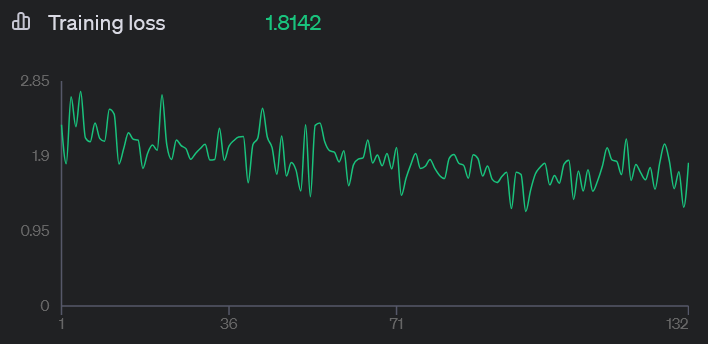

## 6) Evaluation

Testing on a small article i wrote myself during an internship

In [ ]:
# Test the fine-tuned model
url = "https://www.atr-software.de/erkennung-von-anomalien-an-einem-lego-modell-durch-bildanalyse-mit-deep-learning/"
article_title = "Erkennung von Anomalien an einem Lego-Modell durch Bildanalyse mit Deep Learning"
model_id = "ft:gpt-4o-mini-2024-07-18:simon-benedict::9qNRsXCW"

article_content = fetch_example_article(url)

In [51]:
display(Markdown(article_content))

Diese Website verwendet Cookies, um Ihnen die bestmögliche Nutzung unserer Website zu ermöglichen. [Bitte lesen Sie unsere Datenschutzerklärung, um weitere Details zu erfahren.](https://www.atr-software.de/datenschutz/)

Alle ablehnenCookies zulassen

![Das Headerbild des Artikels zeigt ein Vepsa Modell von LEGO.](https://www.atr-software.de/www.atr-software.de/wp-content/plugins/a3-lazy-load/assets/images/lazy_placeholder.gif)

In diesem Artikel demonstrieren wir die Anwendbarkeit von Deep Learning für die Anomalieerkennung in Bildern. Unser Ziel ist es, mit Hilfe von Neuronalen Netzen mögliche Fehler am Aufbau eines Vespa-Modells aus Klemmbausteinen zu erkennen.

Bei der Erkennung von Anomalien handelt es sich um die Bestimmung von Abweichungen oder Unregelmäßigkeiten in den Daten, die nicht dem erwarteten Muster oder Verhalten entsprechen. Das ist eine wichtige Aufgabe in vielen Bereichen wie Betrugsprävention, Systemüberwachung und Qualitätssicherung.

Mit diesem Use Case adressieren wir Explainable AI und machen unser System für die Anwender verständlich. Zudem stärken wir das Vertrauen in KI-Lösungen, die für Außenstehende oftmals wie eine Art Blackbox wirken.

### Der erste Ansatz

Zuerst verwendeten wir einen Autoencoder, eine Art neuronales Netz, das Eingabedaten komprimiert und rekonstruiert. Anomalien können erkannt werden, indem man den Rekonstruktionsfehler misst, der die Diskrepanz zwischen Eingabe und rekonstruiertem Ausgang darstellt. Instanzen mit hohen Rekonstruktionsfehlerwerten sind wahrscheinlich Anomalien. In unserem Blog-Artikel [KI-gestützte Fehlererkennung bei einem Vespa-Modell](https://www.atr-software.de/ki-gestuetzte-fehlererkennung-bei-einem-vespa-modell-aus-lego/)
 erklären wir die Funktionsweise genauer. Obwohl mit Autoencodern schon gute Ergebnisse erzielt werden können, sind in jüngster Vergangenheit einige noch fortschrittlichere, komplexere KI-Architekturen entwickelt worden. Diese bauen auf dem gleichen Prinzip auf, haben es aber weiter optimiert. Deshalb testeten und verglichen wir viele dieser neuen Ansätze für unseren Anwendungsfall. 

![Heatmap und Segmentierung eines Blender Modells der LEGO Vespa mit fehlerhaftem Kotflügel](https://www.atr-software.de/www.atr-software.de/wp-content/plugins/a3-lazy-load/assets/images/lazy_placeholder.gif%20%22Heatmap_und_Segmentierung_Blender_Modell_Vespa%22)

_Heatmap und Segmentierung eines fehlenden Kotflügels an einem Vespa-Blender-Modell, die von einem „simplerem“ Autoencoder-Model generiert wurde.  
_

### Optimierung des Modells

Wir entschieden uns für Reverse Distillation in Kombination mit One-Class Bottleneck Embedding (OCBE), um eine bessere Effizienz und Effektivität zu erreichen. Diese Methode liefert eine sehr gut interpretierbare Darstellung der Daten und ermöglicht eine verbesserte Generalisierung für unbekannte Anomalien. Stark vereinfacht ausgedrückt erreicht sie diese bessere Performance durch das Vergleichen von Input und Output, ähnlich dem Prinzip eines Autoencoders. Jedoch findet dies auf verschiedenen Stufen der Codierung und Decodierung der Daten gleichzeitig statt. Ähnlich vielversprechende Ergebnisse ließen sich mit der PatchCore-Architekur erreichen, die sich auf die Rekonstruktion lokaler Patches konzentriert und somit kleinere lokale Anomalien besser erkennen kann

![Heatmap und Segmentierung generiert von Reverse Distillation-Model](https://www.atr-software.de/www.atr-software.de/wp-content/plugins/a3-lazy-load/assets/images/lazy_placeholder.gif%20%22Heatmap_und_Segmentierung_Vespa_Reverse_Distillation_Model%22)

_Heatmap und Segmentierung generiert von Reverse Distillation-Model_ 

Anschließend optimierten wir unser Modell mit Methoden wie der Kreuzvalidierung, die wir während der Auswahl der besten Architektur und Parameter verwendeten, um besonders das häufige Problem von Overfitting zu vermeiden. Mithilfe von Transfer Learning konnten wir Gebrauch von sehr leistungsstarken, auf riesigen Datenmengen trainierten Bild-Klassifizierungs-Modellen machen, um die Anzahl der benötigten Trainingsdaten möglichst gering zu halten. 

Nach sorgfältiger Anpassung unseres Modells auf die in Blender modellierten 3D-Grafiken testeten wir es mit Fotos der realen Lego-Vespa. Dabei bemerkten wir, dass Unterschiede in der Beleuchtung bei der Datenaufnahme das Modell verwirren können, ein Phänomen, das als Verteilungsdrift bekannt ist. 

![Foto der realen Vespa mit überblendeter Maske von fehlendem Teil (links), Heatmap (mitte) und Segmentierung (rechts).](https://www.atr-software.de/erkennung-von-anomalien-an-einem-lego-modell-durch-bildanalyse-mit-deep-learning/links)

_Foto der realen Vespa mit überblendeter Maske von fehlendem Teil (links), Heatmap (mitte) und Segmentierung (rechts)_.

Um diese Herausforderung zu meistern, haben wir in unserer Showcase-Installation ein starkes Studiolicht eingesetzt. Dies führte zu einer gleichmäßigen Beleuchtung und minimierte die Missinterpretationen des Modells.

Abschließend konnten wir erfolgreich demonstrieren, dass KI-gestützte Bildanalyse effektiv zur Erkennung und Lokalisierung von Anomalien im Aufbau von Lego-Vespa-Modellen eingesetzt werden kann. Trotz einiger Herausforderungen, wie der Bewältigung von Verteilungsdrift durch Beleuchtungsunterschiede, zeigt unsere Arbeit das immense Potenzial von Deep Learning in der Qualitätssicherung und Anomalieerkennung. Es bleibt jedoch ein fortlaufender Prozess, die Modelle weiter zu optimieren und an spezifische Anwendungsfälle anzupassen. 

https://www.atr-software.de/wp-content/uploads/2023/07/Titelbild\_Vespa.jpg 1396 1862 Arthur https://www.atr-software.de/wp-content/uploads/2017/03/Logo-RGB\_Web-Header.png Arthur2023-07-20 12:12:142023-07-20 12:50:16Erkennung von Anomalien an einem Lego-Modell durch Bildanalyse mit Deep Learning

[Jahrestagung der GAMM: Spannende Vorträge und Diskussionen in Dresden![Das Bild zeigt die Begrüßung bei der Jahrestagung der GAMM 2023 in der TU Dresden.](https://www.atr-software.de/www.atr-software.de/wp-content/plugins/a3-lazy-load/assets/images/lazy_placeholder.gif)](https://www.atr-software.de/gamm-tagung-2023/)
[![Das Headerbild zeigt die Lernfabrik von fischer Technik im Büro der ATR Software GmbH in Neu-Ulm.](https://www.atr-software.de/www.atr-software.de/wp-content/plugins/a3-lazy-load/assets/images/lazy_placeholder.gif)Eine Fabrik im Miniaturformat](https://www.atr-software.de/eine-fabrik-im-miniaturformat/)

[Nach oben scrollen](#top "Nach oben scrollen")

In [53]:
result = test_fine_tuned_model(client, model_id, article_title, url, article_content, comments_per_level=3, depth=3)
print("Generated Comment Section:")
display(Markdown(result))

Generated Comment Section:



- **lqf** (): This is *so cool*, what a great way to demonstrate the various capabilities of deep learning!<p>So any chance for a step by step tutorial? :(
  - **h65Fbpq67T5SQPy4** (): Thank you, I&#x27;ll set out on writing a tutorial. Stay tuned.<p>I&#x27;ll probably also put a video on YouTube together.
    - **nothisiowa** (): doxxed by own npc
    - **noone__** (): I love the vespa factory on the roof. Makes for great playable real estate especially with that roof color blending them together.
    - **Cyst** (): You have a fake vespa. There is a note on the container which states the fake one will be sent if you don&#x27;t pay extra for the original one. I&#x27;d be embaraassed if I were you.
  - **onclick42** (): Here is a Youtube video where I used to obtain the 3D images for training as well as the additional training dataf.<p>https:&#x2F;&#x2F;www.youtube.com&#x2F;watch?v=JyNIQZNFkKg
    - **doctroid** (): The link is borked.
    - **onclick42** (): It works just fine for me, but here it is again.<p>https:&#x2F;&#x2F;www.youtube.com&#x2F;watch?v=JyNIQZNFkKg
  - **chickendinner** (): I&#x27;d love to see if the &quot; Reverse Distillation in Combination with One-Class Bottleneck Embedding&quot; architecture coould somehow be pushed to play automodding video games by create input-output pairs by recording gameplay. (especially how ppls game in such involved maps as skyrim, if you mod append quests or people…)
- **slackfan** (): Congrats - very nice work. Was a bit skeptical when seeing article title but loved the write-up.  At end of day we are still on the tip of the iceberg with computer vision &amp; AI tools - it is growing up exponentially!
- **fastalx** (): Nice post!<p>Now all you need to do is hook it up to a robotic arm with a gripper and you have a unique build assistant. I could definitely use one of those!
  - **JavaLizard** (): Bonus points if the assistant attempts to correct the builder&#x27;s mistakes (within reason).
    - **d_pic** (): Maybe add a wake word so it knows you are asking for help first.<p>&#x27;Alexa, I am screwing up and cant find the right piece. Help!&#x27;<p>&#x27;STOP! STOP! STOP! You have the wrong piece!&#x27;<p>&#x27;Invalid request. Did not find the piece. RESUME AS INSTRUCTED!&#x27;<p>&#x27;Augh. Fine.&#x27;
- **rocketandworld** (): What happens with &quot;anomaly&quot; detection, when humans aren&#x27;t very reliable or right either? Like when the boss or most employees say something is &quot;wrong&quot; because they just don&#x27;t like it, even when it technically is correct. It might&nbsp;be that you have to do as the people in charge want, whether it matches factually to the standards or something else.(this happens in many departments like marketing, design, programming)
  - **running_the_muppet** (): Anything done for aesthetic purposes is subjective. AI don&#x27;t have aesthetics , just algorithms.
  - **kuhl** (): You main hire engineers and physicists to set the standards
    - **rocketandworld** (): Sure (but that&#x27;s one departement). But sometimes the boss has even more power and what their gut says gets done.
- **mouseskate** (): Great application of Machine Learning.<p>In addition to learning how to apply ML in practice, it also addresses some of its besetting challenges:<p>- Explainable AI/understanding your model: this proof of principle gives us human-understandable outputs of the model, which goes some way in addressing the concerns around AI being a black box<p>- ML monitoring needs: I would bet that a major area of cost with deployment of ML is monitoring model runtime performance and retraining when a model &quot;ages-out&quot; by obtaining reduced accuracy over time (as it sees new, unseen data). This example shows a potential method for doing just that, by performing anomaly detection on its inputs.<p>At my company we realised years ago that we needed to build anomaly detection into our product (as part of our Monitoring module), and it turned into a very big and complex project. I now see there are probably several pre-trained ML models we could leverage using tools like this.<p>I am now wondering if the converse is handled as well with this project: i.e. had the model seen the real-world image of the vespa without a missing part in its training data, would it have been sufficiently well trained to recognise the real-world image as normal (and therefore not an anomaly)?
  - **DuckyB** (): &gt;had the model seen the real-world image of the vespa without a missing part in its training data, would it have been sufficiently well trained to recognise the real-world image as normal (and therefore not an anomaly)?<p>Not a ML expert, but near-100% certitude for all I&#x27;ve read that it won&#x27;t.<p>It will have seen &quot;model1971-red-white-front-left-1.jpg&quot; and similar names as being normal, but it won&#x27;t have seen &quot;Vespa model 1971, 3 wheels, from above, looking very sleek and non-anomalous&quot; etc.<p>ML basically works by correlating patterns.  A certain correlation of pixels in a certain size box means this LEGO part is here, there, or not at all.  A certain other correlation of pixels within the same sized box means that other LEGO part is there, here, or not at all.  What makes it be faced-out vs. faced-in is the faceout vs.-in facing it has of the base, plus pixel-by-correlated-pixel mapping of that facings&#x27;s XYZ planar-distance-from-camera for how-near/clumpy it is of those 2 disprovers.  The way it knows the XY geometries of pixel-location-XY-to-real-or-net-XY-dimension of all these brick part-demention-disposition-XYZ-non-holograms, is the onetime training it got from 2D-&gt;3D-aware video preparation.  Rinse repeat.<p>In the end, it knows basically nothing abstract about these parts and their contingencies, or how to else-denominate  them.  It has let &quot;outside data context&quot; &quot;drift&quot; past it during its training, and no training update whatsoever will ever be able to teach it any.
    - **AmbitiousPurple** (): If we add our own examples with no part and impact by other parts like wear, rain etc?<p>[Upload your real vespa photo in some address and set examples and use your tips there]
    - **mouseskate** (): &gt; Not a ML expert, but near-100% certitude for all I&#x27;ve read that it won&#x27;t.<p>I am not a ML expert either, just a software eng (that once worked on a lot of ML stuff). I suspected it would not be able to model the normal world well enough based on just a few (assuming the training set is small), hence my question. Thanks for the confirmation.<p>I did find it intriguing that the researchers did not answer the question I was posed (and, as you suggest, I am doubtful the net would correctly classify the real photo as normal). This seems like a really important piece of info that should&#x2F;could&#x27;ve been included if known.
    - **dk-bojo** (): &gt; &quot;return to the normal distribution&quot;, hang on, a double negative ??<p>I believe you have fallen foul of a common mistake of the English language, a double negative is actually a positive, an affirmation !  Sometimes people use this &#x27;wrong&#x27; in the accepted sense of a negative in English (I never see nothing) but here I believe this is a proper use. What I mean is the model should send the image to the expert for de-bugging (go back to the normal distribution) if it detects an anomaly it never learned about. (to return to the normal distribution is very familiar phrase from control theory in manufacturing.)
  - **bluebunny** (): You can generate anomalous images by selecting the wrong drive belt in Fusion 360 and hitting render.
  - **cloudjump** (): the &quot;what is normal&quot; question is an interesting one. our brains are quite happy to accept lots of variability as normal.<p>some years ago there was a sit-com with a plot of trying to recognize what a dog looked like. it produced horrible (but interesting) impressions of what an animal was._ probably not too far off an anomaly detection problem._
    - **cowmix** (): &gt; the &quot;what is normal&quot; question is an interesting one. our brains are quite happy to accept lots of variability as normal.<p>To be very reductive, crows are normal, white crows are anomalies, albino crows are anomalies (though perhaps less normal than white crows), percent colored mutant crows are anomalies and very possibly in some cases quite ugly mutant crows are the ugly extreme of anomalies. And we’re not happy with the ugly extreme mutant+anomalous+normal demarcations at all, we’d rather they stayed as individual extremes of ugly outliers&#x2F;anomalies to keep these extremes ungamedstrips of internet communities.
I’m not actually sure what this means, I just had the dawning perception that books that attempt to provide meanings&#x2F;definitions&#x2F;delineate these sorts of draws haven’t quite Ada Lovelaced, or their work was never delivered to those enclaves where new tools in the playing the human game…&#x2F;&#x2F;updating the playbooks of these humangames. I’d love to come across Jenny the crow while out in the dirty cold streets in this world of sad looking busted cars we live in nowdays&hellip;&hellip;and when I did looked at her I was not upset because Jaime wasn’t there that day doing his dirty miserable depressed loser morning another day looking for bread in this town while dodging crankheads doing crank outs so we can keep our mouths right...&#x2F;done in this modeling environments dev+ops=rs&#x2F;soma... ARG<br>
                                          We want to be jurists of these systems not definitely not players of these games?!...human wheels need more time in the dirt patch...
&nbsp;&nbsp;
After rereading I’m not sure even this makes much sense.
    - **cloudjump** (): Also quite reduced. the dog one means trying to computer vision an underlying concept (i.e. category) without being given the category name. (But I would wager the vision system itself isn’t trying to understand the dog concept from scratch, but building on many many images of dogs of all kinds.)
